SLaM (Source, Light and Mass): Mass Total + Source Parametric
=============================================================

SLaM pipelines break the analysis down into multiple pipelines which focus on modeling a specific aspect of the strong
lens, first the Source, then the (lens) Light and finally the Mass. Each of these pipelines has it own inputs which
which customize the model and analysis in that pipeline.

The models fitted in earlier pipelines determine the model used in later pipelines. For example, if the SOURCE PIPELINE
uses a parametric `EllSersic` profile for the bulge, this will be used in the subsequent MASS TOTAL PIPELINE.

Using a SOURCE PARAMETRIC PIPELINE and a MASS TOTAL PIPELINE this SLaM script fits `Imaging` of a strong lens system, where
in the final model:

 - The lens galaxy's light is omitted from the data and model.
 - The lens galaxy's total mass distribution is an `EllPowerLaw`.
 - The source galaxy's light is a parametric `EllSersic`.

This uses the SLaM pipelines:

 `source_parametric/no_lens_light`
 `mass_total/no_lens_light`

Check them out for a full description of the analysis!

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import os
import sys
from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

sys.path.insert(0, os.getcwd())
import slam

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`







































































__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

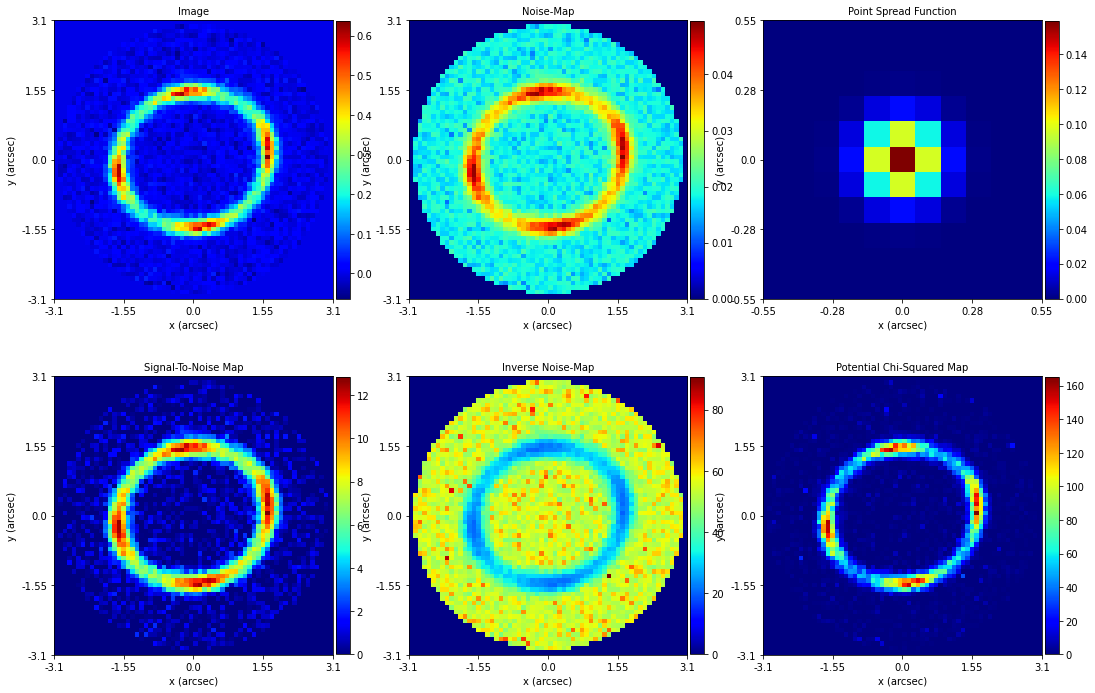

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
    name=dataset_name,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "slam")

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__HYPER SETUP__

The `SetupHyper` determines which hyper-mode features are used during the model-fit.

In [5]:
setup_hyper = al.SetupHyper(
    hyper_galaxies_lens=False,
    hyper_galaxies_source=False,
    hyper_image_sky=None,
    hyper_background_noise=None,
)

__SOURCE PARAMETRIC PIPELINE (no lens light)__

The SOURCE PARAMETRIC PIPELINE (no lens light) uses one search to initialize a robust model for the source galaxy's 
light, which in this example:
 
 - Uses a parametric `EllSersic` bulge for the source's light (omitting a disk / envelope).
 - Uses an `EllIsothermal` model for the lens's total mass distribution with an `ExternalShear`.

 __Settings__:
 
 - Mass Centre: Fix the mass profile centre to (0.0, 0.0) (this assumption will be relaxed in the MASS TOTAL PIPELINE).

In [6]:
analysis = al.AnalysisImaging(dataset=imaging)

source_parametric_results = slam.source_parametric.no_lens_light(
    path_prefix=path_prefix,
    unique_tag=dataset_name,
    analysis=analysis,
    setup_hyper=setup_hyper,
    mass=af.Model(al.mp.EllIsothermal),
    shear=af.Model(al.mp.ExternalShear),
    source_bulge=af.Model(al.lp.EllSersic),
    mass_centre=(0.0, 0.0),
    redshift_lens=0.5,
    redshift_source=1.0,
)


2021-05-10 14:59:44,894 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  9.45it/s, +200 | bound: 0 | nc: 1 | ncall: 202 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.209]
2021-05-10 14:59:45,146 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:59:45,339 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:59:45,498 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__MASS TOTAL PIPELINE (no lens light)__

The MASS TOTAL PIPELINE (no lens light) uses one search to fits a complex lens mass model to a high level of accuracy, 
using the lens mass model and source model of the SOURCE PIPELINE to initialize the model priors. In this example it:

 - Uses an `EllPowerLaw` model for the lens's total mass distribution [priors initialized from SOURCE 
 PARAMETRIC PIPELINE + The centre if unfixed from (0.0, 0.0)].
 
 - Uses the `EllSersic` model representing a bulge for the source's light [priors initialized from SOURCE 
 PARAMETRIC PIPELINE].
 
 - Carries the lens redshift, source redshift and `ExternalShear` of the SOURCE PIPELINE through to the MASS TOTAL PIPELINE.

In [7]:
analysis = al.AnalysisImaging(dataset=imaging)

mass_results = slam.mass_total.no_lens_light(
    path_prefix=path_prefix,
    unique_tag=dataset_name,
    analysis=analysis,
    setup_hyper=setup_hyper,
    source_results=source_parametric_results,
    mass=af.Model(al.mp.EllPowerLaw),
)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
2021-05-10 14:59:46,350 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00, 103.68it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
2021-05-10 14:59:46,389 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:59:46,561 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:59:46,713 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


Finish.